## Demos from my good friends at District Data Labs
* http://www.districtdatalabs.com/
* https://github.com/DistrictDataLabs/tribe

# NetworkX Graph Analysis

Social networks have become a fixture of modern life thanks to social networking sites like Facebook and Twitter. Social networks themselves are not new, however. The study of such networks dates back to the early twentieth century, particularly in the field of sociology and anthropology. It is their prevelance in mainstream applciations that have moved these types of studies to the purview of data science. 

The basis for the analyses in this notebook comes from Graph Theory- the mathmatical study of the application and properties of graphs, originally motivated by the study of games of chance. Generally speaking, this involves the study of network encoding, and measuring properties of the graph. Graph theory can be traced back to Euler's work on the Konigsberg Bridges problem (1735). However in recent decades, the rise of the social network has influenced the discpline, particularly with Computer Science graph data structures and databases. 

A Graph, then can be defined as: `G = (V, E)` consiting of a finite set of nodes denoted by `V` or `V(G)` and a collection `E` or `E(G)` of unordered pairs `{u, v}` where `u, v ∈ V`. Less formally, this is a symbolic repreentation of a network and their relationships- a set of linked nodes.

Graphs can be either directed or undirected. Directed graphs simply have ordered relationships, undirected graphs can be seen as bidirectional directed graphs. A directed graph in a social network tends to have directional semantic relationships, e.g. "friends" - Abe might be friends with Jane, but Jane might not reciprocate. Undirected social networks have more general semantic relationships, e.g. "knows". Any directed graph can easily be converted to the more general undirected graph. In this case, the adjacency matrix becomes symmetric.

A few final terms will help us in our discussion. The cardinality of vertices is called the *order* of the Graph, where as the cardinality of the edges is called the *size*. In the above graph, the order is 7 and the size is 10. Two nodes are adjacent if they share an edge, they are also called neighbors and the neighborhood of a vertex is the set of all vertices that a vertex is connected to. The number of nodes in a vertex' neighborhood is that vertex' degree. 

## Required Python Libraries ##

The required external libraries for the tasks in this notebook are as follows:

1. networkx
2. matplotlib
3. python-louvain

Or just run the following 

`pip install --upgrade tribe`

NetworkX is a well maintained Python library for the creation, manipulation, and study of the structure of complex networks. Its tools allow for the quick creation of graphs, and the library also contains many common graph algorithms. In particular NetworkX complements Python's scientific computing suite of SciPy/NumPy, Matplotlib, and Graphviz and can handle graphs in memory of 10M's of nodes and 100M's of links. NetworkX should be part of every data scientist's toolkit. 

NetworkX and Python are the perfect combination to do social network analysis. NetworkX is designed to handle data at scale, data that is relevant to modern scale social networks. The core algorithms that are included are implemented on extremely fast legacy code. Graphs are hugely flexible (nodes can be any hashable type), and there is an extensive set of native IO formats. Finally, with Python- you'll be able to access or use a myriad of data sources from databases to the Internet.

In [118]:
%matplotlib inline

In [119]:
import os
import random
import community

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from tribe.stats import FreqDist

#from tribe.utils import *
#from tribe.stats import *
from operator import itemgetter

## Some Helper constants
FIXTURES = os.path.join(os.getcwd(), "fixtures")
GRAPHML  = os.path.join(FIXTURES, "/root/pipeline/datasets/email/SparkMVP.graphml")

## Example NetworkX Hello World Graph

In [154]:
H = nx.Graph(name="Hello World Graph")
# Also nx.DiGraph, nx.MultiGraph, etc

# Add nodes manually, label can be anything hashable
H.add_node(1, name="Chris Fregly", email="chris@fregly.com")
H.add_node(2, name="Flux Capacitor", email="chris@fluxcapacitor.com")

# Can also add an iterable of nodes: H.add_nodes_from
print nx.info(H)

Name: Hello World Graph
Type: Graph
Number of nodes: 2
Number of edges: 0
Average degree:   0.0000


In [155]:
H.add_edge(1,2, label="friends", weight=0.832)

# Can also add an iterable of edges: H.add_edges_from

In [156]:
print nx.info(H)
# Clearing a graph is easy
H.remove_node(1)
H.clear()

Name: Hello World Graph
Type: Graph
Number of nodes: 2
Number of edges: 1
Average degree:   1.0000


For testing and diagnostics it's useful to generate a random Graph. NetworkX comes with several graph models including:

- Complete Graph `G=nx.complete_graph(100)`
- Star Graph `G=nx.star_graph(100)`
- Erdős-Rényi graph, binomial graph `G=nx.erdos_renyi_graph(100, 0.20)`
- Watts-Strogatz small-world graph `G=nx.watts_strogatz_graph(100, 0.20)`
- Holme and Kim power law `G=nx.powerlaw_cluster_graph(100, 0.20)`

But there are so many more, see [Graph generators](https://networkx.github.io/documentation/latest/reference/generators.html) for more information on all the types of graph generators NetworkX provides. These, however are the best ones for doing research on social networks.

In [157]:
H = nx.erdos_renyi_graph(100, 0.20)

Accessing Nodes and Edges:

In [167]:
print H.nodes()[1:10]
print H.edges()[1:5]
print H.neighbors(3)

[1, 2, 3, 4, 5, 6, 7, 8, 9]
[(0, 1), (0, 98), (0, 67), (0, 37)]
[1, 86, 65, 49, 9, 44, 13, 93, 17, 50, 84, 85, 54, 26, 59, 90, 63]


In [159]:
# For fast, memory safe iteration, use the `_iter` methods

edges, nodes = 0,0
for e in H.edges_iter(): edges += 1
for n in H.nodes_iter(): nodes += 1
    
print "%i edges, %i nodes" % (edges, nodes)

957 edges, 100 nodes


In [162]:
# Accessing the properties of a graph

print H.graph['name']
#H.graph['created'] = strfnow()
print H.graph

gnp_random_graph(100,0.2)
{'name': 'gnp_random_graph(100,0.2)'}


In [174]:
# Accessing the properties of nodes and edges

H.node[1]['color'] = 'red'
H.node[43]['color'] = 'blue'

print H.node[43]
print H.nodes(data=True)[:3]

# The weight property is special and should be numeric
H.edge[0][67]['weight'] = 0.432
H.edge[0][37]['weight'] = 0.123

print H.edge[0][37]
print H.edge[0][67]

{'color': 'blue'}
[(0, {}), (1, {'color': 'red'}), (2, {})]
{'weight': 0.123}
{'weight': 0.432}


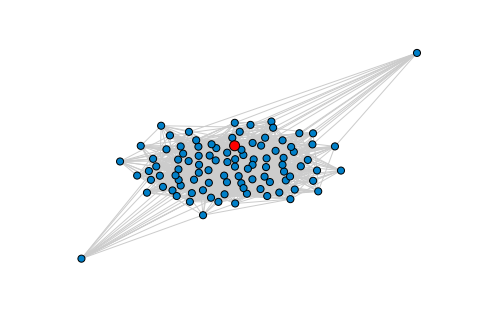

In [175]:
# Accessing the highest degree node
center, degree = sorted(H.degree().items(), key=itemgetter(1), reverse=True)[0]

# A special type of subgraph
ego = nx.ego_graph(H, center)

pos = nx.spring_layout(H)
nx.draw(H, pos, node_color='#0080C9', edge_color='#cccccc', node_size=50)
nx.draw_networkx_nodes(H, pos, nodelist=[center], node_size=100, node_color="r")
plt.show()

# Other subgraphs can be extracted with nx.subgraph

[81, 0, 95]


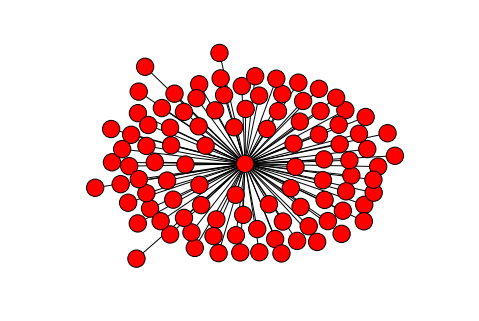

In [176]:
# Finding the shortest path
H = nx.star_graph(100)
print nx.shortest_path(H, random.choice(H.nodes()), random.choice(H.nodes()))

pos = nx.spring_layout(H)
nx.draw(H, pos)
plt.show()

In [179]:
# Preparing for Data Science Analysis
print nx.to_numpy_matrix(H)
print nx.to_scipy_sparse_matrix(G)

[[ 0.  1.  1. ...,  1.  1.  1.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]]
  (0, 13)	1
  (0, 14)	1
  (1, 2)	1
  (1, 4)	1
  (1, 5)	1
  (1, 13)	1
  (1, 14)	1
  (1, 18)	1
  (1, 19)	1
  (1, 28)	1
  (2, 1)	1
  (2, 10)	1
  (2, 21)	1
  (2, 26)	1
  (2, 30)	1
  (3, 4)	1
  (3, 14)	1
  (3, 15)	1
  (3, 18)	1
  (4, 1)	1
  (4, 3)	1
  (4, 10)	1
  (4, 21)	1
  (4, 26)	1
  (4, 30)	1
  :	:
  (27, 18)	1
  (27, 19)	1
  (27, 20)	1
  (27, 22)	1
  (28, 1)	1
  (28, 26)	1
  (28, 30)	1
  (29, 16)	1
  (29, 17)	1
  (29, 18)	1
  (29, 22)	1
  (30, 2)	1
  (30, 4)	1
  (30, 5)	1
  (30, 14)	1
  (30, 15)	1
  (30, 18)	1
  (30, 28)	1
  (31, 15)	1
  (31, 16)	1
  (31, 18)	1
  (31, 19)	1
  (31, 20)	1
  (31, 22)	1
  (31, 23)	1


## Serialization of Graphs

Most Graphs won't be constructed in memory, but rather saved to disk. Serialize and deserialize Graphs as follows:

In [180]:
G = nx.read_graphml(GRAPHML) # opposite of nx.write_graphml

In [181]:
# TODO:  Filter out anything that doesn't include '@' symbol

In [184]:
print nx.info(G)

Name: Email Network
Type: Graph
Number of nodes: 3378
Number of edges: 16845
Average degree:   9.9734


NetworkX has a ton of Graph serialization methods, and most have methods in the following format for serialization format, `format`:

- Read Graph from disk: `read_format`
- Write Graph to disk: `write_format`
- Parse a Graph string: `parse_format`
- Generate a random Graph in format: `generate_format`
    
The list of formats is pretty impressive:

- Adjacency List
- Multiline Adjacency List
- Edge List
- GEXF
- GML
- Pickle
- GraphML
- JSON
- LEDA
- YAML
- SparseGraph6
- Pajek
- GIS Shapefile

The JSON and GraphmL are most noteworthy (for use in D3 and Gephi/Neo4j)

## Initial Analysis of Email Network

We can do some initial analyses on our network using built in NetworkX methods.

In [185]:
# Generate a list of connected components
# See also nx.strongly_connected_components
for component in nx.connected_components(G):
    print len(component)


3378


In [186]:
len([c for c in nx.connected_components(G)])

1

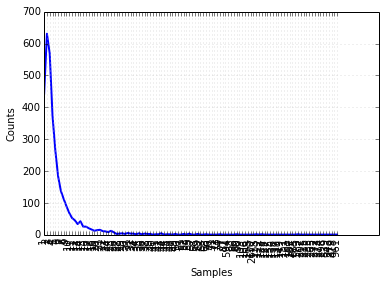

In [187]:
# Get a list of the degree frequencies
# TODO:  This was hijacked from scikit-learn and needs to be put on the PYTHONPATH
dist = FreqDist(nx.degree(G).values())
dist.plot()

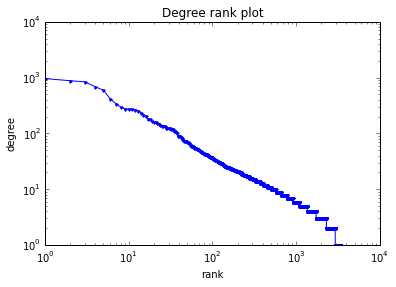

In [188]:
# Compute Power log sequence
degree_sequence=sorted(nx.degree(G).values(),reverse=True) # degree sequence

plt.loglog(degree_sequence,'b-',marker='.')
plt.title("Degree rank plot")
plt.ylabel("degree")
plt.xlabel("rank")

In [189]:
# Graph Properties
print "Order: %i" % G.number_of_nodes()
print "Size: %i" % G.number_of_edges()

Order: 3378
Size: 16845


In [190]:
print "Clustering: %0.5f" % nx.average_clustering(G)

Clustering: 0.73054


In [191]:
print "Transitivity: %0.5f" % nx.transitivity(G)

Transitivity: 0.02661


In [192]:
hairball = nx.subgraph(G, [x for x in nx.connected_components(G)][0])
print "Average shortest path: %0.4f" % nx.average_shortest_path_length(hairball)

Average shortest path: 2.2716


In [193]:
# Node Properties
# TODO:  Filter out user@spark.apache.org to surface many diff clusters
node = 'user@spark.apache.org' # Change to an email in your graph
print "Degree of node: %i" % nx.degree(G, node)
print "Local clustering: %0.4f" % nx.clustering(G, node)

Degree of node: 2677
Local clustering: 0.0033


## Computing Key Players

In the previous graph, we began exploring ego networks and strong ties between individuals in our social network. We started to see that actors with strong ties to other actors created clusters that centered around themselves. This leads to the obvious question: who are the key figures in the graph, and what kind of pull do they have? We'll look at a couple measures of "centrality" to try to discover this: degree centrality, betweeness centrality, closeness centrality, and eigenvector centrality.

### Degree Centrality ###
The most common and perhaps simplest technique for finding the key actors of a graph is to measure the degree of each vertex. Degree is a signal that determines how connected a node is, which could be a metaphor for influence or popularity. At the very least, the most connected nodes are the ones that spread information the fastest, or have the greatest effect on their community. Measures of degree tend to suffer from dillution, and benefit from statistical techniques to normalize data sets. 

In [194]:
def nbest_centrality(graph, metric, n=10, attribute="centrality", **kwargs):
    centrality = metric(graph, **kwargs)
    nx.set_node_attributes(graph, attribute, centrality)
    degrees = sorted(centrality.items(), key=itemgetter(1), reverse=True)
    
    for idx, item in enumerate(degrees[0:n]):
        item = (idx+1,) + item
        print "%i. %s: %0.4f" % item
    
    return degrees

In [195]:
degrees = nbest_centrality(G, nx.degree_centrality, n=15)

1. user@spark.apache.org: 0.7927
2. yuzhihong@gmail.com: 0.2846
3. dev@spark.apache.org: 0.2603
4. sowen@cloudera.com: 0.2484
5. user@spark.incubator.apache.org: 0.2028
6. michael@databricks.com: 0.1759
7. rxin@databricks.com: 0.1238
8. mengxr@gmail.com: 0.1016
9. tdas@databricks.com: 0.0877
10. matei.zaharia@gmail.com: 0.0811
11. pwendell@gmail.com: 0.0808
12. akhil@sigmoidanalytics.com: 0.0805
13. nicholas.chammas@gmail.com: 0.0785
14. cody@koeninger.org: 0.0755
15. andrew@databricks.com: 0.0696


### Betweenness Centrality ###

A _path_ is a sequence of nodes between a star node and an end node where no node appears twice on the path, and is measured by the number of edges included (also called hops). The most interesting path to compute for two given nodes is the _shortest path_, e.g. the minimum number of edges required to reach another node, this is also called the node _distance_. Note that paths can be of length 0, the distance from a node to itself.

In [196]:
# centrality = nx.betweenness_centrality(G)
# normalized = nx.betweenness_centrality(G, normalized=True)
# weighted   = nx.betweenness_centrality(G, weight="weight")

degrees = nbest_centrality(G, nx.betweenness_centrality, n=15)

1. user@spark.apache.org: 0.6497
2. user@spark.incubator.apache.org: 0.1149
3. dev@spark.apache.org: 0.1072
4. yuzhihong@gmail.com: 0.0663
5. sowen@cloudera.com: 0.0482
6. michael@databricks.com: 0.0313
7. rxin@databricks.com: 0.0249
8. chris@fregly.com: 0.0224
9. dev@spark.incubator.apache.org: 0.0149
10. mengxr@gmail.com: 0.0148
11. matei.zaharia@gmail.com: 0.0093
12. cody@koeninger.org: 0.0082
13. nicholas.chammas@gmail.com: 0.0082
14. pwendell@gmail.com: 0.0074
15. tdas@databricks.com: 0.0072


### Closeness Centrality ###

Another centrality measure, _closeness_ takes a statistical look at the outgoing paths fora  particular node, v. That is, what is the average number of hops it takes to reach any other node in the network from v? This is simply computed as the reciprocal of the mean distance to all other nodes in the graph, which can be normalized to `n-1 / size(G)-1` if all nodes in the graph are connected. The reciprocal ensures that nodes that are closer (e.g. fewer hops) score "better" e.g. closer to one as in other centrality scores. 

In [197]:
# centrality = nx.closeness_centrality(graph)
# normalied  = nx.closeness_centrality(graph, normalized=True)
# weighted   = nx.closeness_centrality(graph, distance="weight")

degrees = nbest_centrality(G, nx.closeness_centrality, n=15)

1. user@spark.apache.org: 0.8281
2. yuzhihong@gmail.com: 0.5828
3. dev@spark.apache.org: 0.5748
4. sowen@cloudera.com: 0.5708
5. user@spark.incubator.apache.org: 0.5546
6. michael@databricks.com: 0.5481
7. rxin@databricks.com: 0.5329
8. mengxr@gmail.com: 0.5265
9. matei.zaharia@gmail.com: 0.5211
10. pwendell@gmail.com: 0.5208
11. nicholas.chammas@gmail.com: 0.5203
12. cody@koeninger.org: 0.5178
13. andrew@databricks.com: 0.5177
14. akhil@sigmoidanalytics.com: 0.5164
15. tathagata.das1565@gmail.com: 0.5133


### Eigenvector Centrality ###

The eigenvector centrality of a node, v is proportional to the sum of the centrality scores of it's neighbors. E.g. the more important people you are connected to, the more important you are. This centrality measure is very interesting, because an actor with a small number of hugely influential contacts may outrank ones with many more mediocre contacts. For our social network, hopefully it will allow us to get underneath the celebrity structure of heroic teams and see who actually is holding the social graph together. 

In [198]:
centrality = nx.eigenvector_centrality(graph)
centrality = nx.eigenvector_centrality_numpy(graph)

degrees = nbest_centrality(G, nx.eigenvector_centrality_numpy, n=15)

NameError: name 'graph' is not defined

## Clustering and Cohesion ##

In this next section, we're going to characterize our social network as a whole, rather than from the perspective of individual actors. This task is usually secondary to getting a feel for the most important nodes; but it is a chicken and an egg problem- determining the techniques to analyze and split the whole graph can be informed by key player analyses, and vice versa. 

The _density_ of a network is the ratio of the number of edges in the network to the total number of possible edges in the network. The possible number of edges for a graph of n vertices is n(n-1)/2 for an undirected graph (remove the division for a directed graph). Perfectly connected networks (every node shares an edge with every other node) have a density of 1, and are often called _cliques_. 

In [ ]:
print nx.density(G)

Graphs can also be analyzed in terms of distance (the shortest path between two nodes). The longest distance in a graph is called the _diameter_ of the social graph, and represents the longest information flow along the graph. Typically less dense (sparse) social networks will have a larger diameter than more dense networks. Additionally, the average distance is an interesting metric as it can give you information about how close nodes are to each other. 

In [ ]:
for subgraph in nx.connected_component_subgraphs(G):
    print nx.diameter(subgraph)
    print nx.average_shortest_path_length(subgraph)

Let's actually get into some clustering. The python-louvain library uses NetworkX to perform community detection with the louvain method. Here is a simple example of cluster partitioning on a small, built-in social network.

In [ ]:
partition = community.best_partition(G)
print "%i partitions" % len(set(partition.values()))
nx.set_node_attributes(G, 'partition', partition)

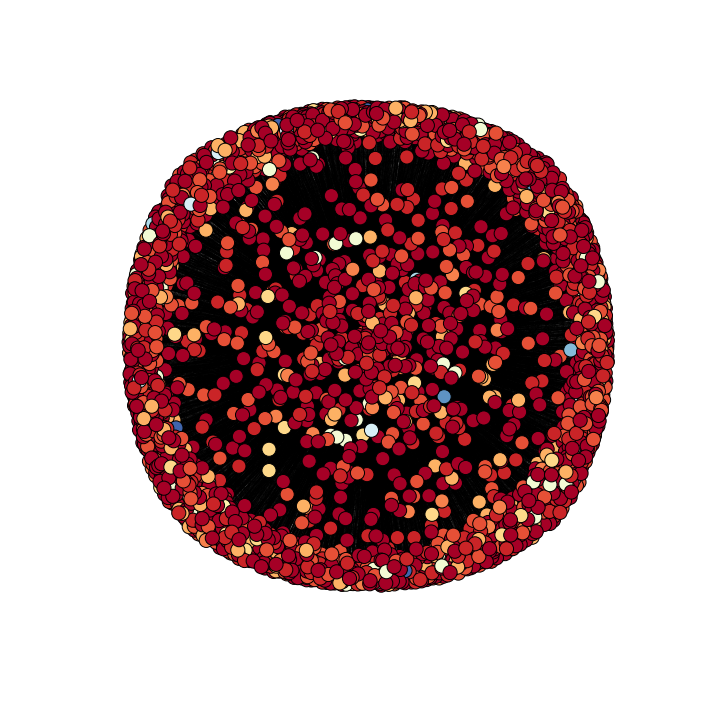

In [151]:
pos = nx.spring_layout(G)
plt.figure(figsize=(12,12))
plt.axis('off')

nx.draw_networkx_nodes(G, pos, node_size=200, cmap=plt.cm.RdYlBu, node_color=partition.values())
nx.draw_networkx_edges(G,pos, alpha=0.5)

## Visualizing Graphs ##

NetworkX wraps matplotlib or graphviz to draw simple graphs using the same charting library we saw in the previous chapter. This is effective for smaller size graphs, but with larger graphs memory can quickly be consumed.  To draw a graph, simply use the `networkx.draw` function, and then use `pyplot.show` to display it. 

In [ ]:
nx.draw(nx.erdos_renyi_graph(20, 0.20))
plt.show()


There is, however, a rich drawing library underneath that lets you customize how the Graph looks and is laid out with many different layout algorithms. Let's take a look at an example using one of the built-in Social Graphs: The Davis Women's Social Club.

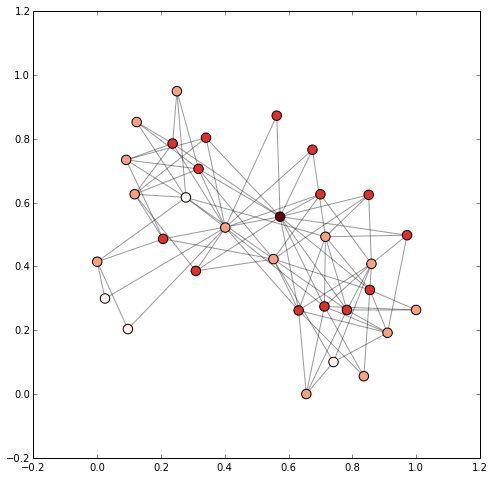

In [153]:
# Generate the Graph
G=nx.davis_southern_women_graph()
# Create a Spring Layout
pos=nx.spring_layout(G)

# Find the center Node
dmin=1
ncenter=0
for n in pos:
    x,y=pos[n]
    d=(x-0.5)**2+(y-0.5)**2
    if d<dmin:
        ncenter=n
        dmin=d

# color by path length from node near center
p=nx.single_source_shortest_path_length(G,ncenter)

# Draw the graph
plt.figure(figsize=(8,8))
nx.draw_networkx_edges(G,pos,nodelist=[ncenter],alpha=0.4)
nx.draw_networkx_nodes(G,pos,nodelist=p.keys(),
                       node_size=90,
                       node_color=p.values(),
                       cmap=plt.cm.Reds_r)